# Using Q-Alchemy for Quantum Chemistry ab initio calculations

This is a wonderful [blog post](https://pennylane.ai/qml/demos/tutorial_initial_state_preparation) by Stephan Fomichev from Xanadu Inc. which we
reproduce here but with using Q-Alchemy.

First, we create $H_3$ as a molecule

In [2]:
from pyscf import gto, scf, ci
from pennylane.qchem import import_state
import numpy as np

from q_alchemy import QAlchemyStatePreparation

R = 1.2
# create the H3+ molecule
mol = gto.M(atom=[["H", (0, 0, 0)], ["H", (0, 0, R)], ["H", (0, 0, 2 * R)]], charge=1)
# perform restricted Hartree-Fock and then CISD
myhf = scf.RHF(mol).run()
myci = ci.CISD(myhf).run()
wf_cisd = import_state(myci, tol=1e-1)
f"CISD-based state vector: {wf_cisd.shape}"

converged SCF energy = -1.13616963888333
E(RCISD) = -1.182690605466227  E_corr = -0.04652096658289713


'CISD-based state vector: (64,)'

In [16]:
hf_primer = ([[3, 0, 0]], np.array([1.0]))
wf_hf = import_state(hf_primer)

We can now use this state to speed up VQE

In [17]:
import pennylane as qml
from pennylane import qchem
from jax import numpy as jnp

# generate the molecular Hamiltonian for H3+
symbols = ["H", "H", "H"]
geometry = jnp.array([[0, 0, 0], [0, 0, R/0.529], [0, 0, 2*R/0.529]])
molecule = qchem.Molecule(symbols, geometry, charge=1)

H2mol, qubits = qchem.molecular_hamiltonian(molecule)
wires = list(range(qubits))
dev = qml.device("default.qubit", wires=qubits)

# create all possible excitations in H3+
singles, doubles = qchem.excitations(2, qubits)
excitations = singles + doubles

The circuit we use is the same as in the [blog post](https://pennylane.ai/qml/demos/tutorial_initial_state_preparation) but with Q-Alchemy as an option.

In [18]:
def circuit(theta, initial_state, use_q_alchemy=True, max_fidelity_loss=0.0, initialization_method="auto"):
    if use_q_alchemy:
        QAlchemyStatePreparation(initial_state, wires=wires, max_fidelity_loss=max_fidelity_loss, initialization_method=initialization_method)
    else:
        qml.StatePrep(initial_state, wires=wires)
    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(theta[i], wires=excitation)
        else:
            qml.SingleExcitation(theta[i], wires=excitation)
    return qml.expval(H2mol)

circuit_VQE = qml.QNode(circuit, dev)

Now we start with the HF state and see how many iterations it takes to converge.

In [19]:
import optax
import jax
jax.config.update("jax_enable_x64", True)

def cost_fn_hf(param):
    return circuit_VQE(param, initial_state=wf_hf, use_q_alchemy=True, max_fidelity_loss=0.05, initialization_method="auto")

opt = optax.sgd(learning_rate=0.4)  # sgd stands for StochasticGradientDescent
theta = jnp.array(jnp.zeros(len(excitations)))
delta_E, iteration = 10, 0
results_hf = []
opt_state = opt.init(theta)
prev_energy = cost_fn_hf(theta)

But before we start, let's check the number of resources required to run the circuit.

In [20]:
compiled_circuit = qml.compile(circuit_VQE, basis_set=["CNOT", "X", "SX", "RZ"])
print("Q-Alchemy")
print(qml.specs(compiled_circuit)(theta, initial_state=wf_hf, use_q_alchemy=True, max_fidelity_loss=0.05, initialization_method="auto")["resources"].gate_sizes)
print("Standard QSP")
print(qml.specs(compiled_circuit)(theta, initial_state=wf_hf, use_q_alchemy=False)["resources"].gate_sizes)

Q-Alchemy
defaultdict(<class 'int'>, {1: 130, 2: 64})
Standard QSP
defaultdict(<class 'int'>, {1: 129, 2: 126})


So it is 194 gates, of which 64 are CNOT gates and 130 are rotation gates. The depth is 119.

In [21]:
# run the VQE optimization loop until convergence threshold is reached
while abs(delta_E) > 1e-5:
    gradient = jax.grad(cost_fn_hf)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)
    new_energy = cost_fn_hf(theta)
    delta_E = new_energy - prev_energy
    prev_energy = new_energy
    results_hf.append(new_energy)
    if len(results_hf) % 5 == 0:
        print(f"Step = {len(results_hf)},  Energy = {new_energy:.6f} Ha")
f"Starting with HF state took {len(results_hf)} iterations until convergence."

Step = 5,  Energy = -1.173803 Ha
Step = 10,  Energy = -1.179865 Ha
Step = 15,  Energy = -1.181626 Ha
Step = 20,  Energy = -1.182239 Ha
Step = 25,  Energy = -1.182461 Ha
Step = 30,  Energy = -1.182543 Ha


'Starting with HF state took 31 iterations until convergence.'

Now that we are done with the HF state, let's try the CISD state.

In [22]:
def cost_fn_cisd(param):
    return circuit_VQE(param, initial_state=wf_cisd, use_q_alchemy=True, max_fidelity_loss=0.05, initialization_method="auto")

theta = jnp.array(jnp.zeros(len(excitations)))
delta_E, iteration = 10, 0
results_cisd = []
opt_state = opt.init(theta)
prev_energy = cost_fn_cisd(theta)

In [23]:
compiled_circuit = qml.compile(circuit_VQE, basis_set=["CNOT", "X", "SX", "RZ"])
print("Q-Alchemy")
print(qml.specs(compiled_circuit)(theta, initial_state=wf_cisd, use_q_alchemy=True, max_fidelity_loss=0.05, initialization_method="auto")["resources"].gate_sizes)
print("Q-Alchemy PS")
print(qml.specs(compiled_circuit)(theta, initial_state=wf_cisd, use_q_alchemy=True, max_fidelity_loss=1.0, initialization_method="auto")["resources"].gate_sizes)
print("Standard QSP")
print(qml.specs(compiled_circuit)(theta, initial_state=wf_cisd, use_q_alchemy=False)["resources"].gate_sizes)

Q-Alchemy
defaultdict(<class 'int'>, {1: 146, 2: 67})
Q-Alchemy PS
defaultdict(<class 'int'>, {1: 130, 2: 64})
Standard QSP
defaultdict(<class 'int'>, {1: 203, 2: 188})


In this case the CISD state is not as simple as the HF state, so it takes more resources. We see 213 (194 above) gates and depth 133 (129 above), but only 3 more CNOT gates than the HF state!

In [24]:
while abs(delta_E) > 1e-5:
    gradient = jax.grad(cost_fn_cisd)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)
    new_energy = cost_fn_cisd(theta)
    delta_E = new_energy - prev_energy
    prev_energy = new_energy
    results_cisd.append(new_energy)
    if len(results_cisd) % 5 == 0:
        print(f"Step = {len(results_cisd)},  Energy = {new_energy:.6f} Ha")
f"Starting with CISD state took {len(results_cisd)} iterations until convergence."

Step = 5,  Energy = -1.181365 Ha
Step = 10,  Energy = -1.182433 Ha
Step = 15,  Energy = -1.182565 Ha


'Starting with CISD state took 16 iterations until convergence.'

The convergence with a maximum fidelity loss of 0.05 is much better for the CISD state: it converges faster, and it uses only a few more gates.

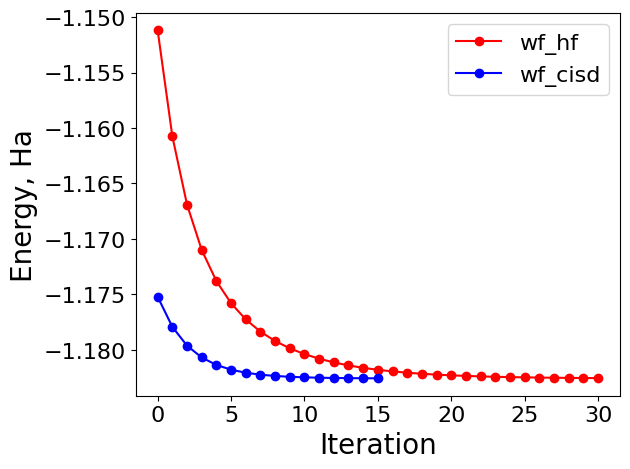

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(len(results_hf)), results_hf, color="r", marker="o", label="wf_hf")
ax.plot(range(len(results_cisd)), results_cisd, color="b", marker="o", label="wf_cisd")
ax.legend(fontsize=16)
ax.tick_params(axis="both", labelsize=16)
ax.set_xlabel("Iteration", fontsize=20)
ax.set_ylabel("Energy, Ha", fontsize=20)
plt.tight_layout()
plt.show()